In [4]:
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

C:\Users\bruno\AppData\Local\Temp\ipykernel_29872\3345283657.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
C:\Users\bruno\AppData\Local\Temp\ipykernel_29872\3345283657.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_path)


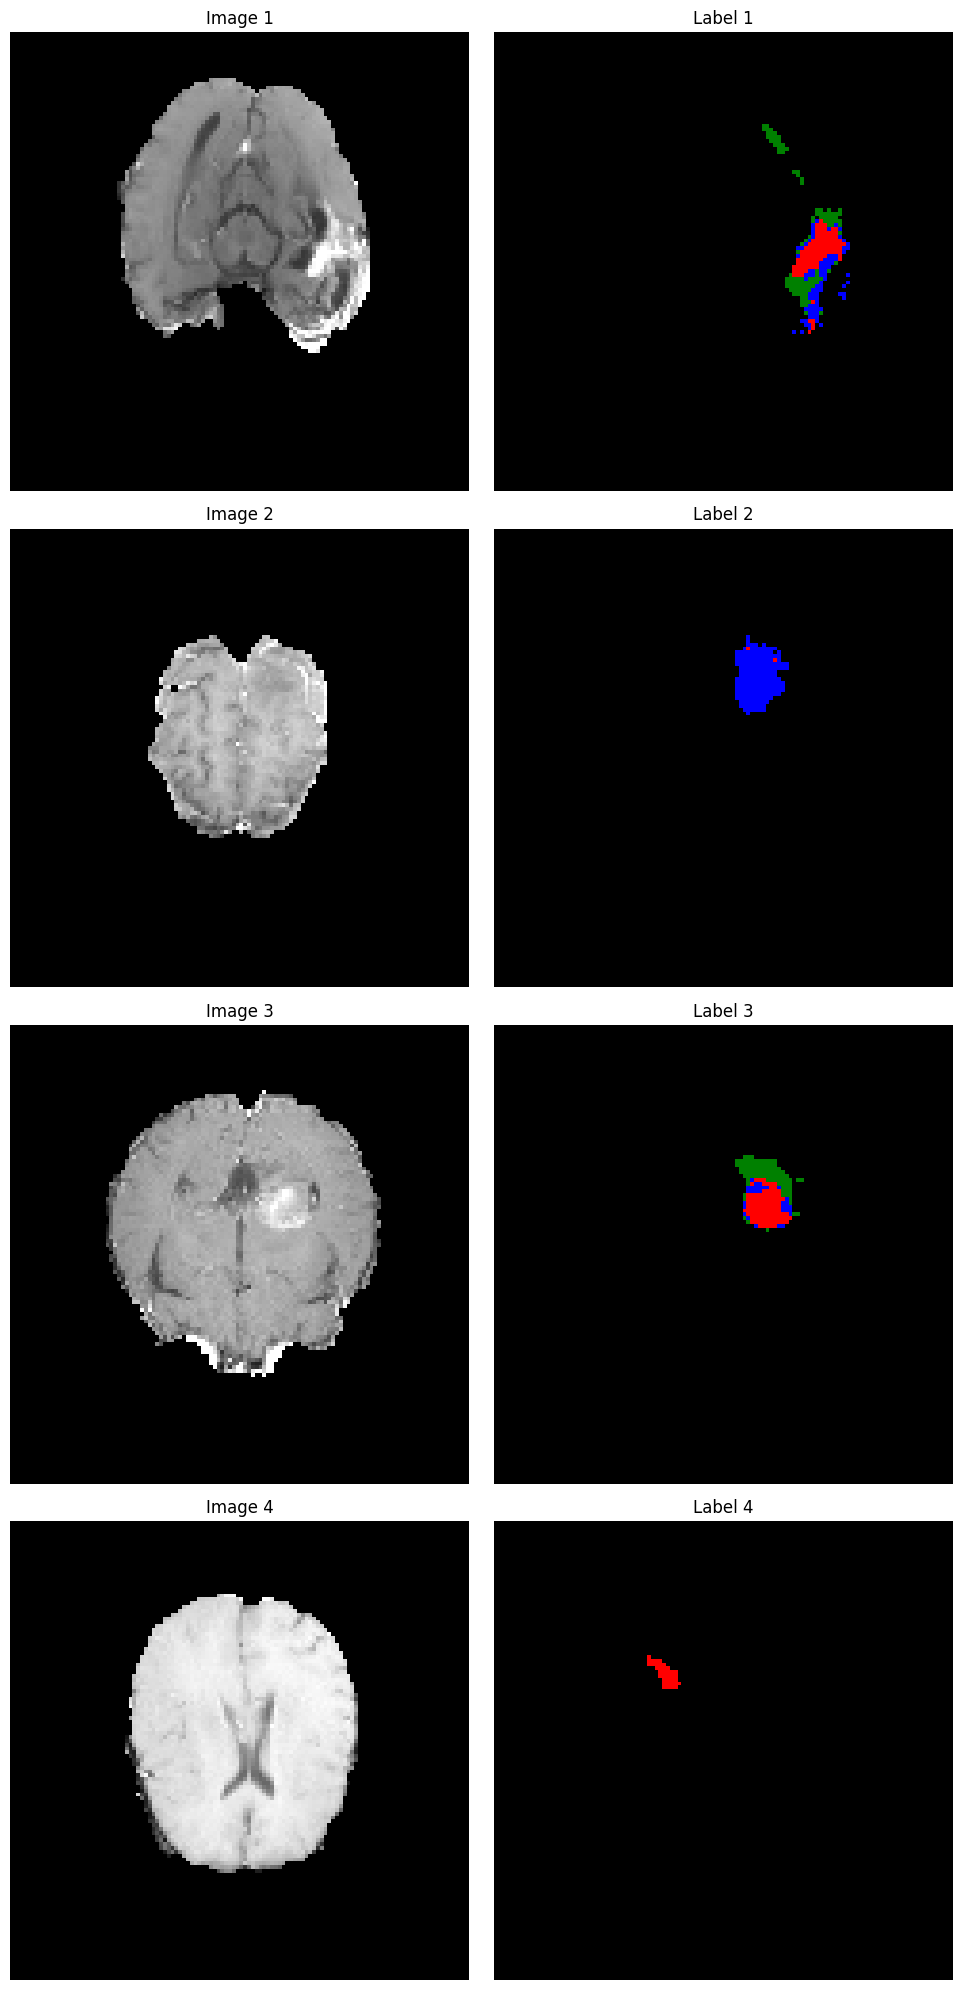

In [10]:
train_images_path = 'Task01_BrainTumour_2D/training_images'
train_labels_path = 'Task01_BrainTumour_2D/training_labels/'
image_files = [f for f in os.listdir(train_images_path) if f.endswith(('.png'))]
# print(image_files)
selected_images = random.sample(image_files, min(4, len(image_files)))
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
for i, image_file in enumerate(selected_images):
    # Load image and label
    img_path = os.path.join(train_images_path, image_file)
    label_path = os.path.join(train_labels_path, image_file)
    img = imageio.imread(img_path)
    label = imageio.imread(label_path)
    # Plot image
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Image {i+1}')
    # Plot label
    axes[i, 1].imshow(label, cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Label {i+1}')
plt.tight_layout()
plt.show()

In [21]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []
        for _ in range(batch_size):
            idx = np.random.randint(len(self.images))
            image, label = self.__getitem__(idx)
            images.append(image)
            labels.append(label)
        # Convert lists to numpy arrays
        images = np.stack(images)
        labels = np.stack(labels)
        # Add channel dimension for images (NCXY)
        images = images[:, np.newaxis, :, :]
        return images, labels

In [12]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )
        

        n = int(n / 2) # 64
        self.upconv4 = nn.ConvTranspose2d(n*2, n, kernel_size=2, stride=2)
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
            )

        
        n = int(n / 2) # 32
        self.upconv3 = nn.ConvTranspose2d(n*2, n, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(n*2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
            )
 
        n = int(n / 2) # 16
        self.upconv2 = nn.ConvTranspose2d(n*2, n, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
                nn.Conv2d(n*2, n, kernel_size=3, padding=1),
                nn.BatchNorm2d(n),
                nn.ReLU(),
                nn.Conv2d(n, n, kernel_size=3, padding=1),
                nn.BatchNorm2d(n),
                nn.ReLU()
                )
        
        self.final_conv = nn.Conv2d(n, output_channel, kernel_size=1)


    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        x = self.upconv4(x)
        x = torch.cat([x, conv3_skip], dim=1)
        x = self.dec_conv4(x)
        x = self.upconv3(x)
        x = torch.cat([x, conv2_skip], dim=1)
        x = self.dec_conv3(x)
        x = self.upconv2(x)
        x = torch.cat([x, conv1_skip], dim=1)
        x = self.dec_conv2(x)
        x = self.final_conv(x)
        
        return x

In [23]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')


Device: cpu


C:\Users\bruno\AppData\Local\Temp\ipykernel_29872\2606199436.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, image_name))
C:\Users\bruno\AppData\Local\Temp\ipykernel_29872\2606199436.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_name)


In [24]:
# Train the model
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    start_iter = time.time()
    model.train()
    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device,dtype=torch.long)
    logits = model(images)
    # Perform optimisation and print out the training loss
    eval_loss = criterion(logits, labels)
    optimizer.zero_grad()
    eval_loss.backward()
    optimizer.step()
    print('Iter {0}/{1} - Loss: {2:.4f} - Time: {3:.2f}s'.format(it, num_iter, eval_loss.item(), time.time() - start_iter))
    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            test_images, test_labels = test_set.get_random_batch(eval_batch_size)
            test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
            test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
            test_logits = model(test_images)
            test_loss = criterion(test_logits, test_labels)
            print('Test Loss: {0:.4f}'.format(test_loss.item()))
        # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Iter 1/10000 - Loss: 1.2054 - Time: 0.87s
Iter 2/10000 - Loss: 1.1389 - Time: 0.58s
Iter 3/10000 - Loss: 1.1037 - Time: 0.56s
Iter 4/10000 - Loss: 1.0921 - Time: 0.81s
Iter 5/10000 - Loss: 1.0582 - Time: 0.74s
Iter 6/10000 - Loss: 1.0249 - Time: 0.61s
Iter 7/10000 - Loss: 1.0049 - Time: 0.52s
Iter 8/10000 - Loss: 0.9905 - Time: 0.52s
Iter 9/10000 - Loss: 0.9735 - Time: 0.53s
Iter 10/10000 - Loss: 0.9571 - Time: 0.54s
Iter 11/10000 - Loss: 0.9472 - Time: 0.55s
Iter 12/10000 - Loss: 0.9468 - Time: 0.56s
Iter 13/10000 - Loss: 0.9165 - Time: 0.53s
Iter 14/10000 - Loss: 0.8960 - Time: 0.61s
Iter 15/10000 - Loss: 0.8836 - Time: 0.69s
Iter 16/10000 - Loss: 0.8732 - Time: 0.59s
Iter 17/10000 - Loss: 0.8569 - Time: 0.61s
Iter 18/10000 - Loss: 0.8604 - Time: 0.52s
Iter 19/10000 - Loss: 0.8458 - Time: 0.52s
Iter 20/10000 - Loss: 0.8238 - Time: 0.54s
Iter 21/10000 - Loss: 0.8153 - Time: 0.55s
Iter 22/10000 - Loss: 0.8018 - Time: 0.53s
Iter 23/10000 - Loss: 0.8058 - Time: 0.52s
Iter 24/10000 - Loss

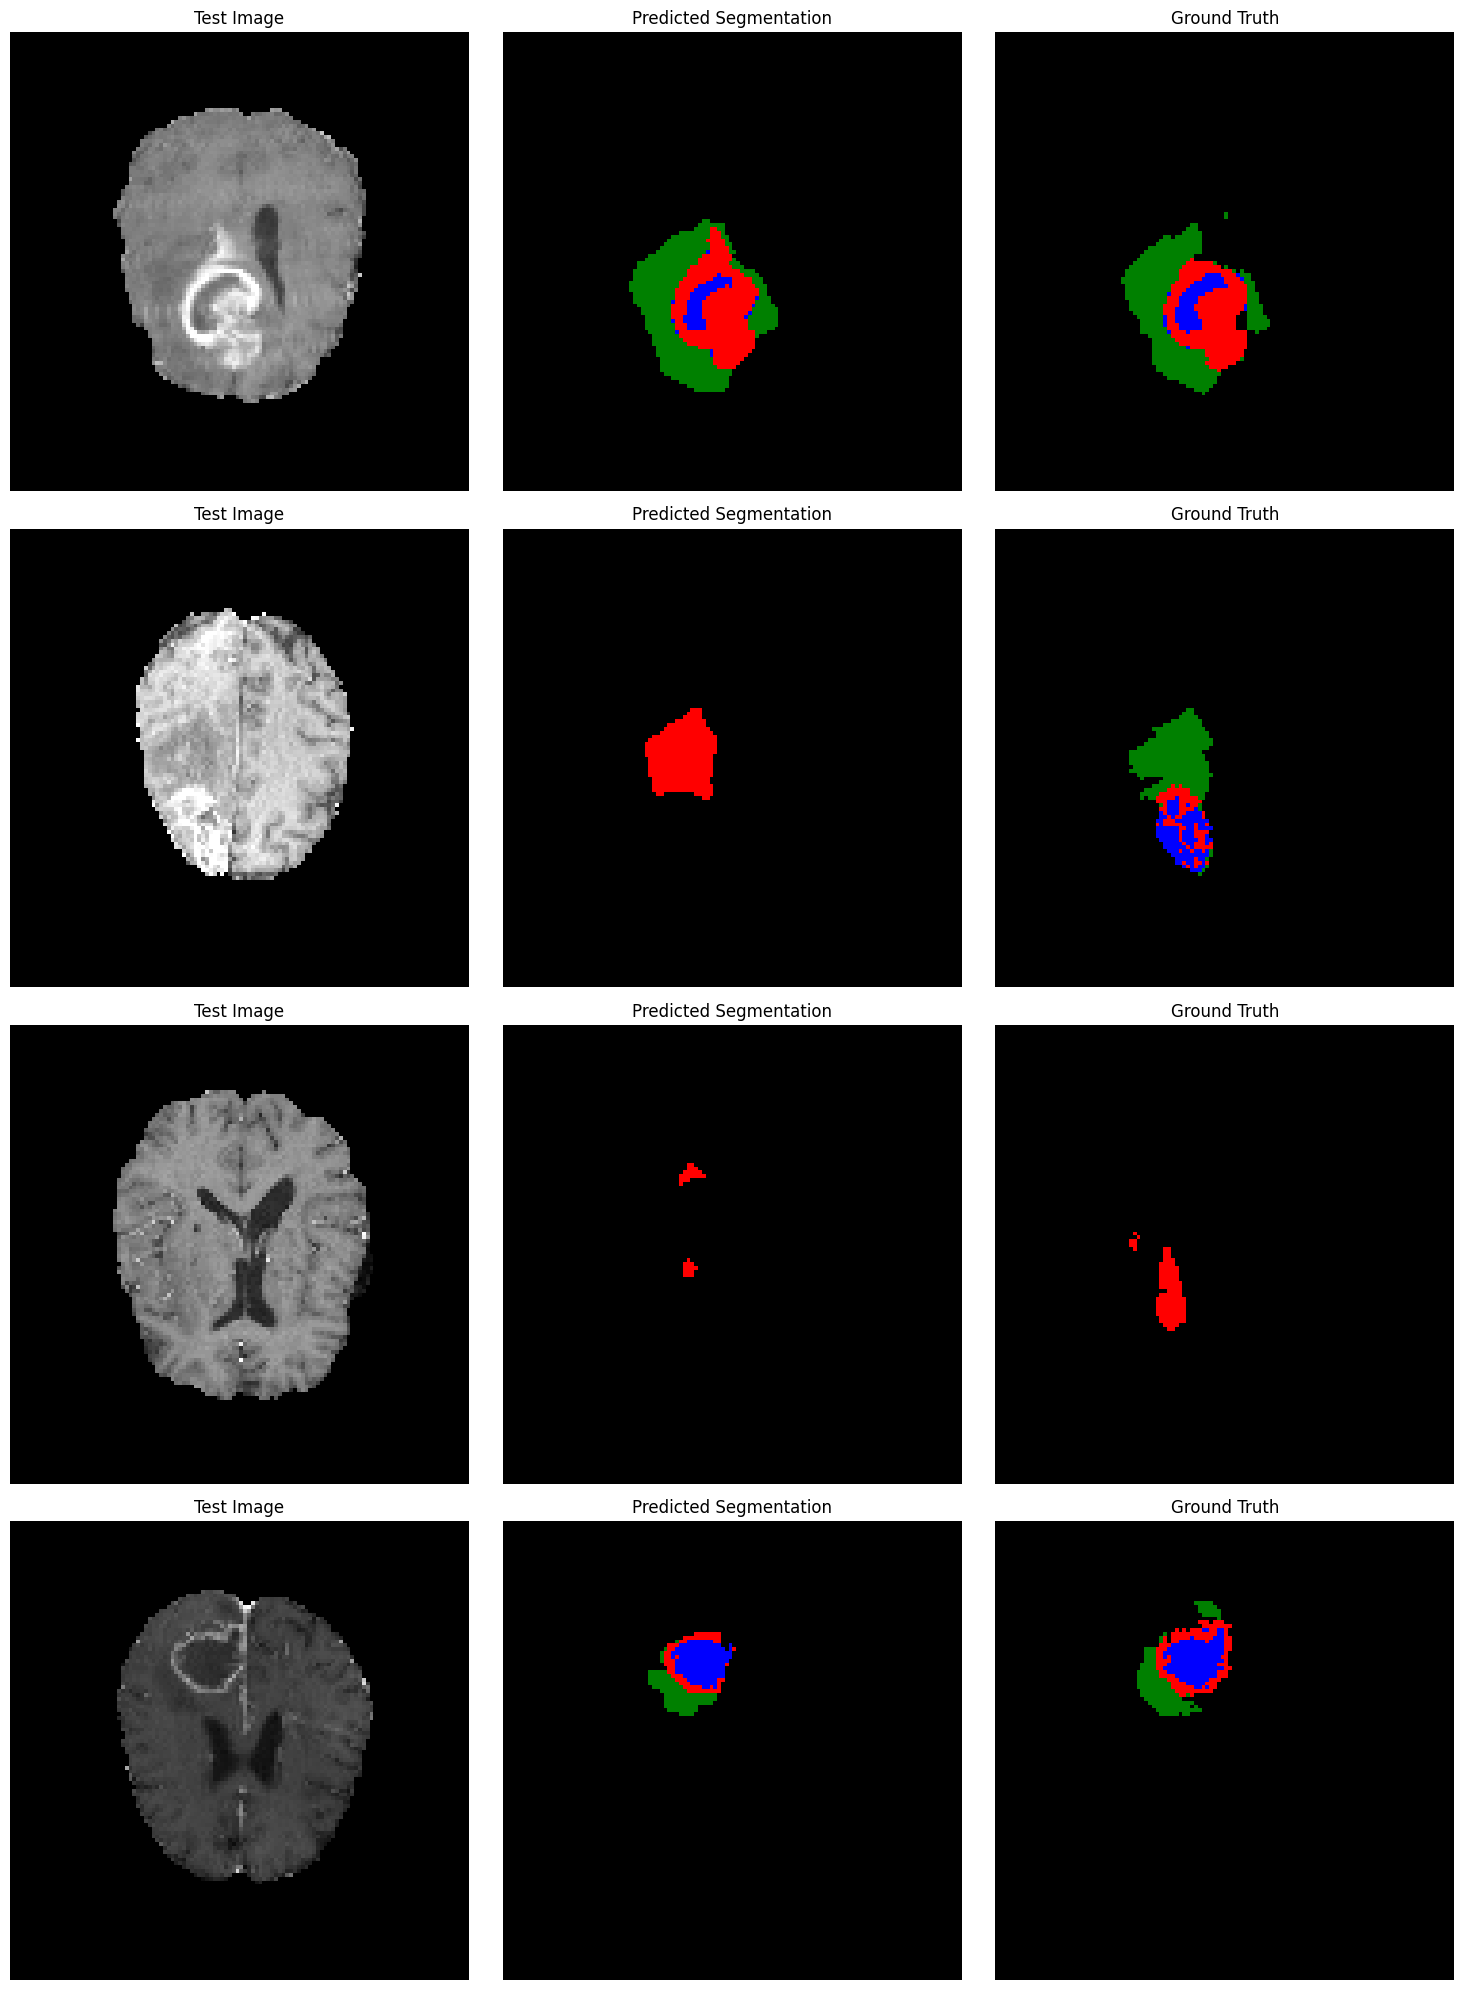

In [30]:
model.eval()
with torch.no_grad():
    test_images, test_labels = test_set.get_random_batch(4)
    test_images = torch.from_numpy(test_images).to(device, dtype=torch.float32)
    test_labels = torch.from_numpy(test_labels).to(device, dtype=torch.long)
    pred_logits = model(test_images)
    pred_labels = torch.argmax(pred_logits, dim=1)
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    for i in range(4):
        # Original image
        axes[i,0].imshow(test_images[i,0].cpu(), cmap='gray')
        axes[i,0].axis('off')
        axes[i,0].set_title('Test Image')
        # Predicted segmentation
        axes[i,1].imshow(pred_labels[i].cpu(), cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
        axes[i,1].axis('off')
        axes[i,1].set_title('Predicted Segmentation')
        # Ground truth
        axes[i,2].imshow(test_labels[i].cpu(), cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
        axes[i,2].axis('off')
        axes[i,2].set_title('Ground Truth')
    plt.tight_layout()
    plt.show()


In [31]:
def dice_coefficient(pred, target, num_classes=4):
    dice_scores = []
    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()
        intersection = torch.sum(pred_c * target_c)
        union = torch.sum(pred_c) + torch.sum(target_c)
        dice = (2. * intersection) / (union)
        dice_scores.append(dice.item())
    return dice_scores
def iou_score(pred, target, num_classes=4):
    iou_scores = []
    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()
        intersection = torch.sum(pred_c * target_c)
        union = torch.sum(pred_c) + torch.sum(target_c) - intersection
        iou = (intersection) / (union)
        iou_scores.append(iou.item())
    return iou_scores
def pixel_accuracy(pred, target):
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total


model.eval()
with torch.no_grad():
    test_images = []
    test_labels = []
    for i in range(len(test_set)):
        image, label = test_set[i]
        test_images.append(image)
        test_labels.append(label)
    test_images = np.stack(test_images)[:, np.newaxis, :, :]
    test_labels = np.stack(test_labels)
    test_images = torch.from_numpy(test_images).to(device, dtype=torch.float32)
    test_labels = torch.from_numpy(test_labels).to(device, dtype=torch.long)
    pred_logits = model(test_images)
    pred_labels = torch.argmax(pred_logits, dim=1)
    dice_scores = dice_coefficient(pred_labels, test_labels)
    iou_scores = iou_score(pred_labels, test_labels)
    acc = pixel_accuracy(pred_labels, test_labels)
    print(f"Dice Coefficient per class: {dice_scores}")
    print(f"IoU Score per class: {iou_scores}")
    print(f"Pixel Accuracy: {acc:.4f}")


Dice Coefficient per class: [0.9956382513046265, 0.6324129104614258, 0.6124836802482605, 0.7795454859733582]
IoU Score per class: [0.9913143515586853, 0.4624297320842743, 0.44142451882362366, 0.6387337446212769]
Pixel Accuracy: 0.9892
